In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
#import matplotlib
#matplotlib.rcParams['text.usetex'] = True

# Definicion de constantes y malla

In [2]:
#define las constantes necesarias

#constantes de curvatura 
kc = -0.05 
sk = 0.03

#constantes de densidad
srho = sk
rhoc = 0.01

#constantes de shear

ssig = 0.025
sigc = 0.

#constantes del fondo a z=0

OmCDM=0.2589
OmB = 0.0486
OmK = 0.
OmL = 1.-OmB-OmCDM-OmK
H0 = 67.74 #km/(s*Mpc)
c = 299792.458 #km/s

print('OmB = ', OmB)

#constantes del fondo a z=23 (para probar el codigo)

z=100.

#Hini = 4416.9 #km/(s*Mpc)

Hini = np.sqrt(H0**2*((OmCDM+OmB)*(1+z)**3 + OmL)) #km/(s*Mpc)

print('Hini =', Hini)

OmLin = OmL*(H0/Hini)**2. 
OmM = 1.-OmLin 
OmCDMin = OmM*(OmCDM/(OmB + OmCDM))
OmBin = OmM*(OmB/(OmB + OmCDM))
OmK = 0.

Gyr = 31557600000000000. # en s
Mpc = 3.08567758128*10**(19) # en km
Dt0 = 13.662 * Gyr
Hinis = Hini/Mpc # H inicial en segundos
Dtau0 = Dt0*Hinis # tiempo adimensional

print('Dtau0 = ', Dtau0)

#ecuacion de estado 
wb = 0.
wcdm = 0.

# constantes de velocidad relativa

sv = 0.025
rv = 0.01
vc = 0.

l = 60. #*Mpc # escala característica

#a = c/(l*Hini)
a = 1.

L = c/(Hini)

print('l = ', l)
print('OmCDMin = ', OmCDMin)
print('OmBin = ', OmBin)
print('OmLin = ', OmLin)
print('L (Mpc)= ', L)

OmB =  0.0486
Hini = 38128.549822851906
Dtau0 =  532.743292659923
l =  60.0
OmCDMin =  0.8419493791787563
OmBin =  0.15804843502544438
OmLin =  2.185795799326585e-06
L (Mpc)=  7.862676639758348


In [3]:
#define la malla 
n=1000
r0=0.
rn=0.2
h=(rn-r0)/n
r=[]
for i in range(0,n+1):
    b = r0 + i*h
    r.append(b)
#print(r)

# Sistema de ecuaciones y Condiciones Iniciales

In [4]:
def SistEcs3(y,t):
    #y = np.zeros(8*(n+1))
    Th = y[::8]
    Y = y[1::8]
    Ch = y[2::8]
    B = y[3::8]
    sig = y[4::8]
    rho = y[5::8]
    Q = y[6::8]
    rhob = y[7::8]
    
    dydt = np.empty_like(y)
    dThdt = dydt[::8]
    dYdt = dydt[1::8]
    dChdt = dydt[2::8]
    dBdt = dydt[3::8]
    dsigdt = dydt[4::8]
    drhodt = dydt[5::8]
    dQdt = dydt[6::8]
    drhobdt = dydt[7::8]
    
    p = 1./3.*(Q/B)**2./rhob
    PP = -p
    #M = 1./2.*Y*(Y**2.*(sig+Th)**2.-a**2.*Ch**2./B**2.+1.)
    W = np.zeros(n+1)
    
    for i in range(0,n+1):
        if i == 0:
            W[i] = 0.
        else:
            W[i] = -(rho[i]+rhob[i]+OmLin)/2.+1./2.*((sig[i]+Th[i])**2.+a**2./Y[i]**2.*(1.-Ch[i]**2./B[i]**2.))-3./2.*PP[i]
    
    dThdt[0] = -1./2.*(rho[0]+rhob[0])+OmLin-Th[0]**2.
    dYdt[0] = 0.
    dChdt[0] = Ch[0]*Th[0]
    dBdt[0] = B[0]*Th[0]
    dsigdt[0] = 0.
    drhodt[0] = -3.*rho[0]*Th[0]
    dQdt[0] = 0.
    drhobdt[0] = -3.*rhob[0]*Th[0]
    
    for i in range(1, n+1):
        dThdt[i] = -1./2.*(rho[i]+rhob[i]+3.*p[i])+OmLin-2.*sig[i]**2.-Th[i]**2.
        dYdt[i] = Y[i]*(Th[i]+sig[i])
        dChdt[i] = -2.*Ch[i]*sig[i]+Ch[i]*Th[i]+(3./(2.*a))*Q[i]*Y[i]
        dBdt[i] = B[i]*(Th[i]-2.*sig[i])
        dsigdt[i] = sig[i]**2.-2.*sig[i]*Th[i]+3./2.*PP[i]-W[i]
        drhodt[i] = -3.*rho[i]*Th[i]
        dQdt[i] = -3.*Th[i]*Q[i]-3.*a*(p[i]-p[i-1])/h+6.*a*PP[i]*Ch[i]/Y[i]
        #drhobdt[i] = -3.*(rhob[i]+p[i])*Th[i]-6.*PP[i]*sig[i]-2.*a*Q[i]*Ch[i]/(Y[i]*B[i]**2.)-(a/B[i]**2.)*(Q[i]-Q[i-1])/h+(a*Q[i]/B[i]**3.)*(B[i]-B[i-1])/h
        drhobdt[i] = -3.*(rhob[i])*Th[i] #solo para LTB
    return dydt
    

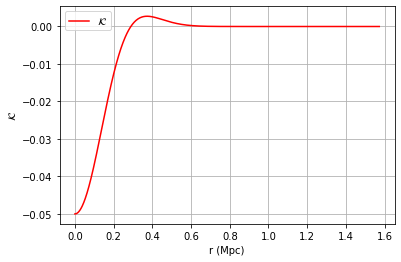

In [5]:
#define las funciones de curvatura, densidad y ricci espacial iniciales

def kini(r):
    Kin = kc*r**2*np.exp(-(r/sk)**2)
    return Kin

def rhoin(r):
    rhoi = OmCDMin*(1. - rhoc*np.exp(-(r/srho)**2))
    return rhoi

def R3in(r):
    R3i = np.exp(-(r/sk)**2)*kc/(sk**2)*(-4.*r**2+6.*sk**2)
    return R3i

def Bin(r):
    Bi = 1./np.sqrt(1-kini(r))
    return Bi

def vin(r):
    vi = vc*r**2.*np.exp(-((r-rv)/sv)**2.)
    return vi

def gamin(r):
    gami = 1./(1.-(vin(r)/Bin(r))**2.)
    return gami

def rhobin(r):
    rhobi = gamin(r)*OmBin*(1. - rhoc*np.exp(-(r/srho)**2))
    return rhobi

def OmLi(r):
    OmLi = OmLin
    return OmLi

def sigin(r):
    sigin = sigc*r**2.*np.exp(-(r/ssig)**2)
    return sigin


vinvec = np.zeros(n+1)
r2  = np.zeros(n+1)

for i in range(0,n+1):
    vinvec[i] = R3in(r[i])/6.
    r2[i] = r[i]*L
    
    
#rr = np.linspace(0.0, 1., 1000)
x = vinvec
#x1 = rhoin(rr)
#x2 = R3in(rr)

plt.plot(r2,x,'r',label=r'$\mathcal{K}$')

axes = plt.gca()

plt.legend(loc="upper left")
plt.xlabel('r (Mpc)')
plt.ylabel(r'$\mathcal{K}$')

plt.grid(True)

#plt.savefig('Kin.png',bbox_inches='tight')


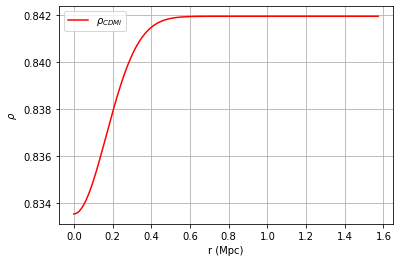

In [6]:
f = np.zeros(8*(n+1)) #de la misma forma que el arreglo de variables, definimos el arreglo de 
                      #condiciones iniciales 
Th0 = f[0::8]
Y0 = f[1::8]
Ch0 = f[2::8]
B0 = f[3::8]
sig0 = f[4::8]
rho0 = f[5::8]
Q0 = f[6::8]
rhob0 = f[7::8]


for i in range(0, n+1):
    Y0[i] = r[i]
    Th0[i] = np.sqrt(rhoin(r[i]) + rhobin(r[i]) + OmLi(r[i]) + sigin(r[i])**2. - 1./6.*R3in(r[i]))
    Ch0[i] = 1.
    B0[i] = Ch0[i]/np.sqrt(1.-kini(r[i]))
    sig0[i] = sigin(r[i])
    rho0[i] = rhoin(r[i])
    Q0[i] = rhobin(r[i])*vin(r[i])
    rhob0[i] = rhobin(r[i])
    
#sig0 = -np.gradient(Th0,r)

    
#W0 = -(rho0+rhob0)/2.+1./2.*Y0**3.*(sig0+Th0)**2.+(a**2.)/2.*(-Ch0**2./B0**2.+1.)*Y0-1./2.*(Q0/B0)**2./rhob0
#W1 = -(rho0+rhob0)/2.+1./2.*(sig0+Th0)**2.+a**2./(2.*Y0**2.)*(1.-Ch0**2./B0**2.)+1./2.*(Q0/B0)**2./rhob0
#M0 = 1./2.*Y0**3.*(sig0+Th0)**2.+a**2.*(-Ch0**2./B0**2.+1.)*Y0


#plt.plot(r,Y0**2,label='Y0^3')
plt.plot(r2,rho0,'r',label=r'$\rho_{CDMi}$')
#plt.plot(r,rhob0,label='rhob0')
#plt.plot(r,W0,label='W0')

axes = plt.gca()

plt.legend(loc="upper left")
plt.xlabel('r (Mpc)')
plt.ylabel(r'$\rho$')

plt.grid(True)

#plt.savefig('rhoCDMin.png',bbox_inches='tight')

# Resolucion del sistema y presentacion de resultados

In [7]:
#se obtiene la solucion del sistema

tspan = np.linspace(0., Dtau0, 1000)
sol = odeint(SistEcs3, f, tspan)


sol

#np.savetxt('solV300.txt',sol) #guarda la solucion en un .txt


array([[1.01980391e+00, 0.00000000e+00, 1.00000000e+00, ...,
        8.41949379e-01, 0.00000000e+00, 1.58048435e-01],
       [5.66690297e-01, 0.00000000e+00, 1.49105115e+00, ...,
        2.59885243e-01, 0.00000000e+00, 4.87849471e-02],
       [3.93177164e-01, 0.00000000e+00, 1.91507906e+00, ...,
        1.24564610e-01, 0.00000000e+00, 2.33829280e-02],
       ...,
       [2.08275000e-03, 0.00000000e+00, 1.61500451e+02, ...,
        8.46377242e-07, 0.00000000e+00, 1.58879621e-07],
       [2.08154114e-03, 0.00000000e+00, 1.61679874e+02, ...,
        8.43962393e-07, 0.00000000e+00, 1.58426313e-07],
       [2.08033518e-03, 0.00000000e+00, 1.61859392e+02, ...,
        8.41555521e-07, 0.00000000e+00, 1.57974501e-07]])

In [8]:
#se define una matriz de la longitud del numero de pasos temporales en la integracion por el 
#numero de componentes de la maya

ThSol=np.zeros( (len(tspan),n+1) ) 

#se le da a este arreglo de comer las entradas de la solucion tal que cada renglon sea
# la solucion de la expansion Th en la maya 

for j in range(0, len(tspan), 1):
    for i in range(1,n+1):
        ThSol[j,0] = sol[j,0] 
        ThSol[j,i] = sol[j,i*8] 


YSol=np.zeros( (len(tspan),n+1) ) 

#se le da a este arreglo de comer las entradas de la solucion tal que cada renglon sea
# la solucion de Y en la maya 

for j in range(0, len(tspan), 1):
    for i in range(1,n+1):
        YSol[j,0] = sol[j,1] 
        YSol[j,i] = sol[j,(i*8)+1] 

ChSol=np.zeros( (len(tspan),n+1) ) 

#se le da a este arreglo de comer las entradas de la solucion tal que cada renglon sea
# la solucion de Ch en la maya 

for j in range(0, len(tspan), 1):
    for i in range(1,n+1):
        ChSol[j,0] = sol[j,2] 
        ChSol[j,i] = sol[j,(i*8)+2] 


BSol=np.zeros( (len(tspan),n+1) ) 

#se le da a este arreglo de comer las entradas de la solucion tal que cada renglon sea
# la solucion de B en la maya 

for j in range(0, len(tspan), 1):
    for i in range(1,n+1):
        BSol[j,0] = sol[j,3] 
        BSol[j,i] = sol[j,(i*8)+3]  

sigSol=np.zeros( (len(tspan),n+1) ) 

#se le da a este arreglo de comer las entradas de la solucion tal que cada renglon sea
# la solucion del shear sig en la maya 

for j in range(0, len(tspan), 1):
    for i in range(1,n+1):
        sigSol[j,0] = sol[j,4] 
        sigSol[j,i] = sol[j,(i*8)+4]  

QSol=np.zeros( (len(tspan),n+1) ) 

#se le da a este arreglo de comer las entradas de la solucion tal que cada renglon sea
# la solucion del calor Q en la maya 

for j in range(0, len(tspan), 1):
    for i in range(1,n+1):
        QSol[j,0] = sol[j,6] 
        QSol[j,i] = sol[j,(i*8)+6]  
                
rhoSol=np.zeros( (len(tspan),n+1) ) 

#se le da a este arreglo de comer las entradas de la solucion tal que cada renglon sea
# la solucion de la densidad de la cdm rho en la maya 
 

for j in range(0, len(tspan), 1):
    for i in range(1,n+1):
        rhoSol[j,0] = sol[j,5] 
        rhoSol[j,i] = sol[j,(i*8)+5]  
        
rhobSol=np.zeros( (len(tspan),n+1) )
        
#se le da a este arreglo de comer las entradas de la solucion tal que cada renglon sea
# la solucion de la densidad barionica rhob en la maya 

for j in range(0, len(tspan), 1):
    for i in range(1,n+1):
        rhobSol[j,0] = sol[j,7] 
        rhobSol[j,i] = sol[j,(i*8)+7]  


        
#se definen los arreglos de contraste de densidad

deltaSol=np.zeros( (len(tspan),n+1) )

for i in range(0, len(tspan), 1):
    deltaSol[i,:]=rhoSol[i,:]/rhoSol[i,-1]-1
    
deltabSol=np.zeros( (len(tspan),n+1) )

for i in range(0, len(tspan), 1):
    deltabSol[i,:]=rhobSol[i,:]/rhobSol[i,-1]-1
    
# Se define el arreglo de velocidad relativa V, de curvatura k y de PP

VSol=QSol/rhobSol
        
kSol = 1. - (ChSol/BSol)**2.

PPSol = -1./3.*(QSol/BSol)**2./rhobSol    

#se define la W

WSol=np.zeros( (len(tspan),n+1) )

for i in range(0,n+1):
    if i == 0:
        WSol[:,i] = 0.
    else:
        WSol[:,i] = -(rhoSol[:,i]+rhobSol[:,i]+OmLin)/2.+1./2.*((sigSol[:,i]+ThSol[:,i])**2.+a**2./(YSol[:,i]**2.)*(-ChSol[:,i]**2./BSol[:,i]**2.+1.))-3./2.*PPSol[:,i]
        
        
deltaTSol=np.zeros( (len(tspan),n+1) )

for i in range(0, len(tspan), 1):
    deltaTSol[i,:] = (rhobSol[i,:]+rhoSol[i,:])/(rhoSol[i,-1]+rhobSol[i,-1])-1.
    
#ThSol
#YSol
#ChSol
#BSol
#sigSol
#QSol
#rhoSol
#rhobSol

In [9]:
#Calcula el redshift z de cada tiempo dado el factor métrico asintótico (r->infinito) B

z1= np.zeros(len(tspan))

for i in range(len(tspan)):
    z1[i] = BSol[0,-1]/BSol[i,-1]*(1+z)-1



100


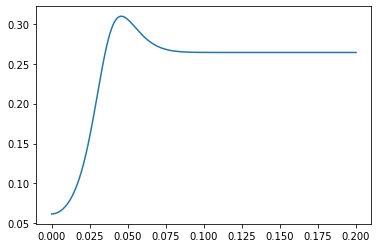

In [10]:
plt.plot(r, rhoSol[-1,:]/ThSol[-1,-1]**2, label='OmCDMf')

pnum = 0

if len(tspan) == 1000:
    pnum = 100
elif len(tspan) == 5000:
    pnum = 500
elif len(tspan) == 10000:
    pnum = 1000
    
print(pnum)

Text(0, 0.5, 'rho')

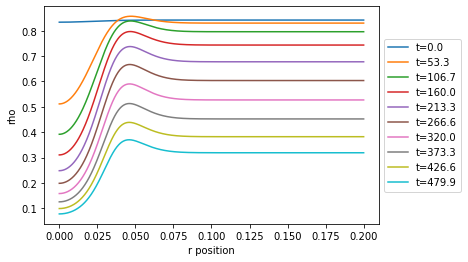

In [11]:
#se realiza una grafica de la soluciones rho vs r para cada paso de tiempo de integracion

for i in range(0, len(tspan), pnum):
    plt.plot(r, rhoSol[i,:]/ThSol[i,-1]**2, label='t={0:1.1f}'.format(tspan[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('r position')
plt.ylabel('rho')

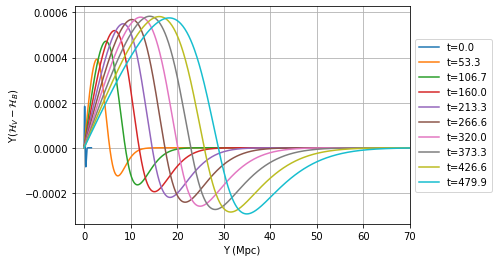

In [12]:
#se realiza una grafica de la soluciones Th vs r para cada paso de tiempo de integracion

for i in range(0, len(tspan), pnum):
    plt.plot(YSol[i,:]*L, YSol[i,:]*(ThSol[i,:]-ThSol[i,-1]), label='t={0:1.1f}'.format(tspan[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes = plt.gca()
axes.set_xlim([-2,70])
#axes.set_ylim([0.9,1.1])
plt.xlabel(r'Y (Mpc)')
plt.ylabel(r'Y($\mathcal{H}_V-\mathcal{H}_B$)')

axes = plt.gca()


plt.grid(True)


#plt.savefig('YThev.png',bbox_inches='tight')

Text(0, 0.5, 'Y')

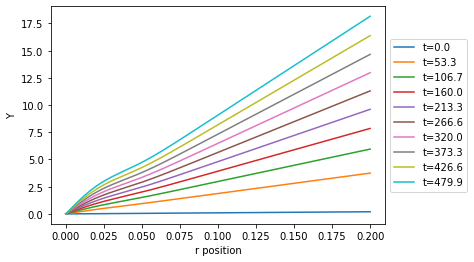

In [13]:
#se realiza una grafica de la soluciones Y vs r para cada paso de tiempo de integracion

for i in range(0, len(tspan), pnum):
    plt.plot(r, YSol[i,:], label='t={0:1.1f}'.format(tspan[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('r position')
plt.ylabel('Y')

Text(0, 0.5, 'Ch')

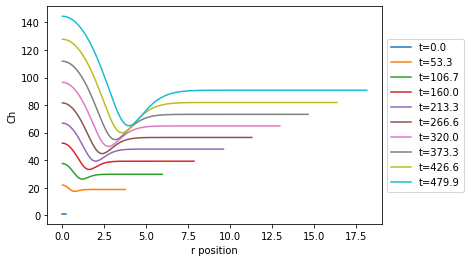

In [14]:
#se realiza una grafica de la soluciones Ch vs r para cada paso de tiempo de integracion

for i in range(0, len(tspan), pnum):
    plt.plot(YSol[i,:], ChSol[i,:], label='t={0:1.1f}'.format(tspan[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes = plt.gca()
#axes.set_xlim([0,0.013])
plt.xlabel('r position')
plt.ylabel('Ch')

Text(0, 0.5, 'B')

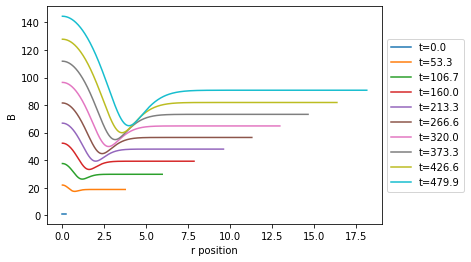

In [15]:
#se realiza una grafica de la soluciones B vs r para cada paso de tiempo de integracion

for i in range(0, len(tspan), pnum):
    plt.plot(YSol[i,:], BSol[i,:], label='t={0:1.1f}'.format(tspan[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes = plt.gca()
#axes.set_xlim([0,0.2])
plt.xlabel('r position')
plt.ylabel('B')

Text(0, 0.5, 'sig')

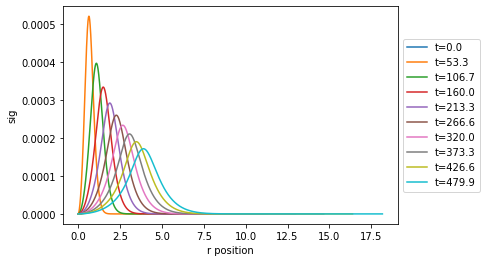

In [16]:
#se realiza una grafica de la soluciones sig vs r para cada paso de tiempo de integracion

for i in range(0, len(tspan), pnum):
    plt.plot(YSol[i,:], sigSol[i,:], label='t={0:1.1f}'.format(tspan[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('r position')
plt.ylabel('sig')

Text(0, 0.5, 'Q')

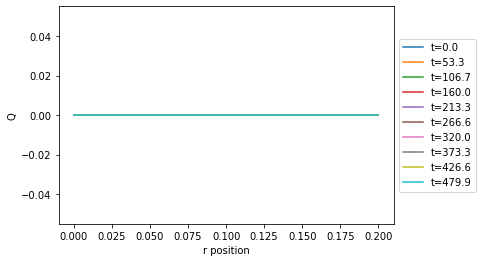

In [17]:
#se realiza una grafica de la soluciones Q vs r para cada paso de tiempo de integracion

for i in range(0, len(tspan), pnum):
    plt.plot(r, QSol[i,:], label='t={0:1.1f}'.format(tspan[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('r position')
plt.ylabel('Q')

Text(0, 0.5, 'V')

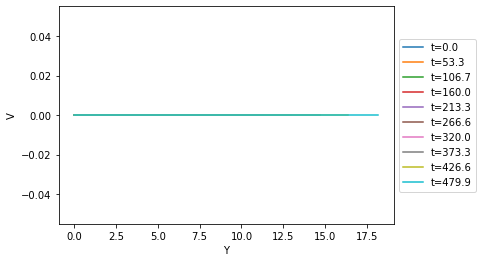

In [18]:
#se realiza una grafica de la soluciones V vs Y para cada paso de tiempo de integracion

for i in range(0, len(tspan), pnum):
    plt.plot(YSol[i,:], VSol[i,:], label='t={0:1.1f}'.format(tspan[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes = plt.gca()
#axes.set_xlim([0,0.2])
plt.xlabel('Y')
plt.ylabel('V')

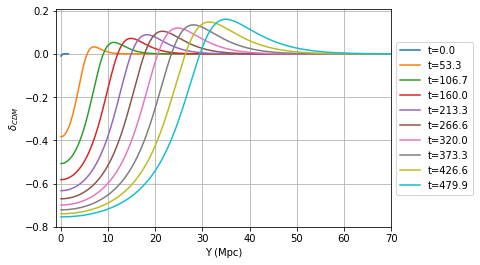

In [19]:
#se realiza una grafica de la soluciones rho vs r para cada paso de tiempo de integracion

for i in range(0, len(tspan), pnum):
    plt.plot(YSol[i,:]*L, deltaSol[i,:], label='t={0:1.1f}'.format(tspan[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes = plt.gca()
axes.set_xlim([-1,70])
plt.xlabel('Y (Mpc)')
plt.ylabel(r'$\delta_{CDM}$')

axes = plt.gca()


plt.grid(True)


#plt.savefig('deltacdmev.png',bbox_inches='tight')

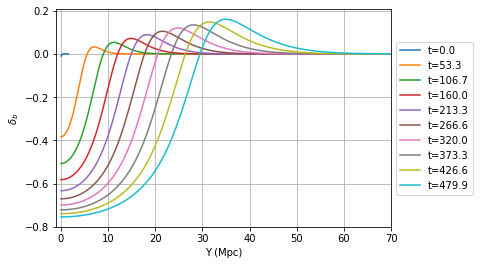

In [20]:
#se realiza una grafica de la soluciones rho vs r para cada paso de tiempo de integracion

for i in range(0, len(tspan), pnum):
    plt.plot(YSol[i,:]*L, deltabSol[i,:], label='t={0:1.1f}'.format(tspan[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Y (Mpc)')
plt.ylabel(r'$\delta_b$')

axes = plt.gca()
axes.set_xlim([-1,70])


plt.grid(True)


#plt.savefig('deltabev.png',bbox_inches='tight')

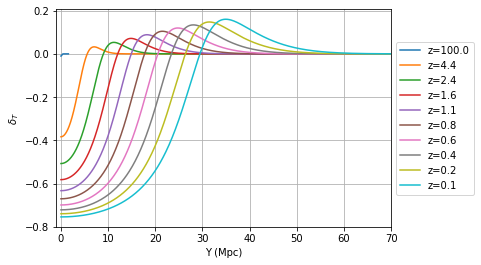

In [21]:
#se realiza una grafica de la soluciones rho vs r para cada paso de tiempo de integracion

for i in range(0, len(tspan), pnum):
    plt.plot(YSol[i,:]*L, deltaTSol[i,:], label='z={0:1.1f}'.format(z1[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Y (Mpc)')
plt.ylabel(r'$\delta_{T}$')

axes = plt.gca()
axes.set_xlim([-1,70])


plt.grid(True)


#plt.savefig('deltaTevz.png',bbox_inches='tight')

Text(0, 0.5, 'k')

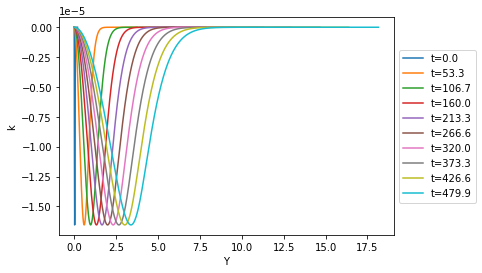

In [22]:
#se realiza una grafica de la soluciones k vs r para cada paso de tiempo de integracion
for i in range(0, len(tspan), pnum):
    plt.plot(YSol[i,:], kSol[i,:], label='t={0:1.1f}'.format(tspan[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Y')
plt.ylabel('k')


[ 0.00000000e+00 -7.38088609e-07 -2.96211096e-06 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]


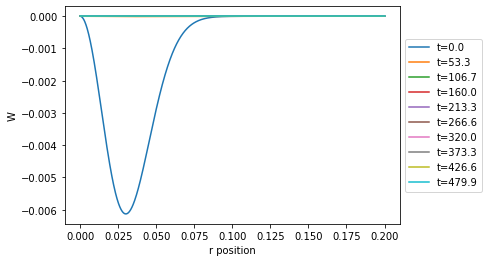

In [23]:
#grafica las soluciones de W

for i in range(0, len(tspan), pnum):
    plt.plot(r, WSol[i,:], label='t={0:1.1f}'.format(tspan[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('r position')
plt.ylabel('W')

print(WSol[0,:])

<ipython-input-24-ea0469ec4cb9>:15: RuntimeWarning: divide by zero encountered in double_scalars
  R3Sol[j,i] = 1./(3.*YSol[j,i]**2.)*(kSol[j,i]+2.*YSol[j,i]/h*((ChSol[j,i]/BSol[j,i]**3.)*(BSol[j,i+1]-BSol[j,i])-(1/BSol[j,i]**2.)*(ChSol[j,i+1]-ChSol[j,i])))
<ipython-input-24-ea0469ec4cb9>:15: RuntimeWarning: invalid value encountered in double_scalars
  R3Sol[j,i] = 1./(3.*YSol[j,i]**2.)*(kSol[j,i]+2.*YSol[j,i]/h*((ChSol[j,i]/BSol[j,i]**3.)*(BSol[j,i+1]-BSol[j,i])-(1/BSol[j,i]**2.)*(ChSol[j,i+1]-ChSol[j,i])))
<ipython-input-24-ea0469ec4cb9>:26: RuntimeWarning: divide by zero encountered in double_scalars
  R32Sol[j,i] = 1./(3.*YSol[j,i]**2.*ChSol[j,i])*(kSol[j,i]*ChSol[j,i]+YSol[j,i]/h*(kSol[j,i+1]-kSol[j,i]))
<ipython-input-24-ea0469ec4cb9>:26: RuntimeWarning: invalid value encountered in double_scalars
  R32Sol[j,i] = 1./(3.*YSol[j,i]**2.*ChSol[j,i])*(kSol[j,i]*ChSol[j,i]+YSol[j,i]/h*(kSol[j,i+1]-kSol[j,i]))


Text(0, 0.5, 'Hamiltonian Constraint')

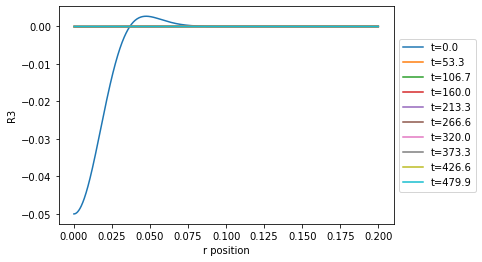

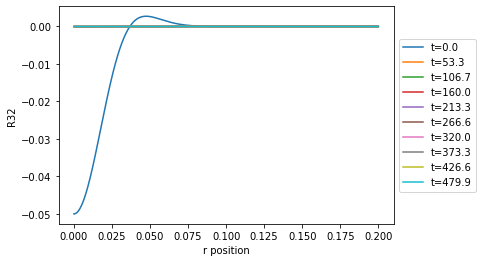

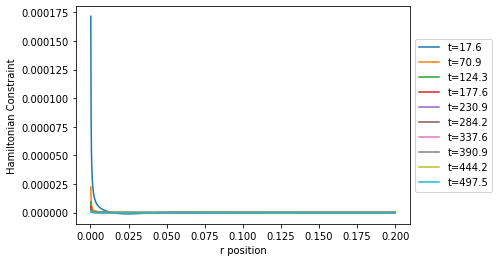

In [24]:
# Checa que se cumplan la constricción hamiltoniana en la solución a cada tiempo 

R30 = np.zeros(n+1)

for j in range(n+1):
    R30[j] = R3in(r[j])

R3Sol = np.zeros( (len(tspan),n+1) )

for i in range(n+1):
    for j in range(0, len(tspan), 1):
        if j == 0:
            R3Sol[j,i] = R3in(r[i])/6.
        elif i == 0 and j != 0:
            R3Sol[j,i] = 1./(3.*YSol[j,i]**2.)*(kSol[j,i]+2.*YSol[j,i]/h*((ChSol[j,i]/BSol[j,i]**3.)*(BSol[j,i+1]-BSol[j,i])-(1/BSol[j,i]**2.)*(ChSol[j,i+1]-ChSol[j,i])))
        else:
            R3Sol[j,i] = 1./(3.*YSol[j,i]**2.)*(kSol[j,i]+2.*YSol[j,i]/h*((ChSol[j,i]/BSol[j,i]**3.)*(BSol[j,i]-BSol[j,i-1])-(1/BSol[j,i]**2.)*(ChSol[j,i]-ChSol[j,i-1])))

R32Sol = np.zeros( (len(tspan),n+1) )

for i in range(n+1):
    for j in range(0, len(tspan), 1):
        if j == 0:
            R32Sol[j,i] = R3in(r[i])/6.
        elif i == 0 and j != 0:
            R32Sol[j,i] = 1./(3.*YSol[j,i]**2.*ChSol[j,i])*(kSol[j,i]*ChSol[j,i]+YSol[j,i]/h*(kSol[j,i+1]-kSol[j,i]))
        else:
            R32Sol[j,i] = 1./(3.*YSol[j,i]**2.*ChSol[j,i])*(kSol[j,i]*ChSol[j,i]+YSol[j,i]/h*(kSol[j,i]-kSol[j,i-1]))


            
#los R3Sol son en realidad K=R3/6            
            
for i in range(0, len(tspan), 100):
    plt.figure(1)
    plt.plot(r, R3Sol[i,:], label='t={0:1.1f}'.format(tspan[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('r position')
plt.ylabel('R3') 
    
for i in range(0, len(tspan), 100):
    plt.figure(2)
    plt.plot(r, R32Sol[i,:], label='t={0:1.1f}'.format(tspan[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('r position')
plt.ylabel('R32')                         

HamConsRHS = rhoSol + rhobSol + OmLin - R32Sol + sigSol**2.

HamCheck = ThSol**2.-HamConsRHS

for i in range(33, len(tspan), 100):
    plt.figure(3)
    plt.plot(r, HamCheck[i,:], label='t={0:1.1f}'.format(tspan[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('r position')
plt.ylabel('Hamiltonian Constraint')

#print(HamCheck)

<ipython-input-25-1ef3b7a1eb17>:7: RuntimeWarning: invalid value encountered in true_divide
  ShearCheck[:,i] = 3.*QSol[:,i]/(2.*a) -(3.*sigSol[:,i]/YSol[:,i])*ChSol[:,i]-((sigSol[:,i+1]-sigSol[:,i])/h)-(ThSol[:,i+1]-ThSol[:,i])/h


[[            nan  7.98966692e-03  2.39659770e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [            nan  1.24762346e-03  6.06722853e-03 ... -1.58570720e-08
  -1.58411972e-08 -1.58253616e-08]
 [            nan -6.59547137e-05  2.12610632e-03 ...  4.64064921e-08
   4.63595881e-08  4.63136709e-08]
 ...
 [            nan  1.53886877e-05 -1.35870232e-05 ...  1.64311937e-07
   1.64146098e-07  1.63987958e-07]
 [            nan  1.53634532e-05 -1.35613011e-05 ...  1.64148827e-07
   1.63983151e-07  1.63825168e-07]
 [            nan  1.53383241e-05 -1.35356075e-05 ...  1.63985724e-07
   1.63820211e-07  1.63662386e-07]]


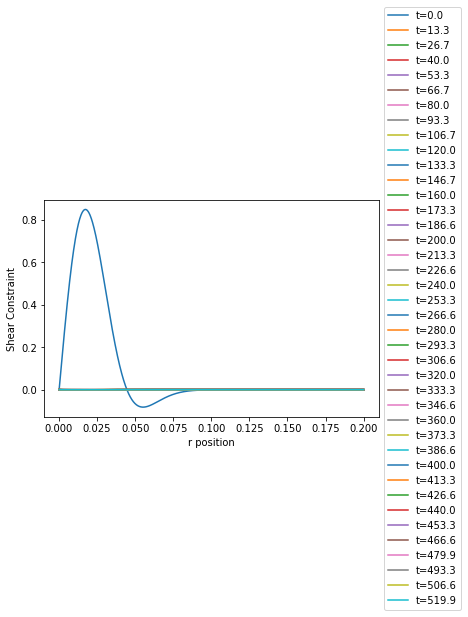

In [25]:
# Checa que se cumplan la constricción del shear en la solución a cada tiempo 

ShearCheck = np.zeros( (len(tspan),n+1) )

for i in range(n+1):
    if i == 0:
        ShearCheck[:,i] = 3.*QSol[:,i]/(2.*a) -(3.*sigSol[:,i]/YSol[:,i])*ChSol[:,i]-((sigSol[:,i+1]-sigSol[:,i])/h)-(ThSol[:,i+1]-ThSol[:,i])/h
    else:
        ShearCheck[:,i] = 3.*QSol[:,i]/(2.*a) -(3.*sigSol[:,i]/YSol[:,i])*ChSol[:,i] -((sigSol[:,i]-sigSol[:,i-1])/h)-(ThSol[:,i]-ThSol[:,i-1])/h

for i in range(0, len(tspan), 25):
    plt.figure(3)
    plt.plot(r, ShearCheck[i,:], label='t={0:1.1f}'.format(tspan[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('r position')
plt.ylabel('Shear Constraint')

print(ShearCheck)

<ipython-input-26-5877d1d0974e>:7: RuntimeWarning: invalid value encountered in true_divide
  WCheck[:,i] = QSol[:,i]*sigSol[:,i]/2. + QSol[:,i]*ThSol[:,i]/2. -a/(h*2.)*(PPSol[:,i+1]-PPSol[:,i])-3./2.*a*(PPSol[:,i]/YSol[:,i])*ChSol[:,i] - 1./6.*a*((rhoSol[:,i+1]+rhobSol[:,i+1]-rhoSol[:,i]-rhobSol[:,i])/h) - (a*WSol[:,i]/YSol[:,i])*ChSol[:,i]-a/3.*((WSol[:,i+1]-WSol[:,i])/h)


[[            nan  4.55022940e-03  1.00009961e-02 ... -2.31296463e-14
  -2.31296463e-14 -2.31296463e-14]
 [            nan  1.05304724e-03  2.01096112e-03 ... -2.35658544e-08
  -2.35422649e-08 -2.35186763e-08]
 [            nan  4.28785354e-04  7.88193223e-04 ... -5.05163802e-08
  -5.04638877e-08 -5.04153417e-08]
 ...
 [            nan -4.60330464e-09  2.70306782e-09 ... -9.40590799e-11
  -9.39643383e-11 -9.38728512e-11]
 [            nan -5.31129668e-09  2.97661071e-09 ... -9.38212947e-11
  -9.37258609e-11 -9.36350700e-11]
 [            nan -4.61380947e-09  2.67119645e-09 ... -9.35745802e-11
  -9.34789354e-11 -9.33883828e-11]]


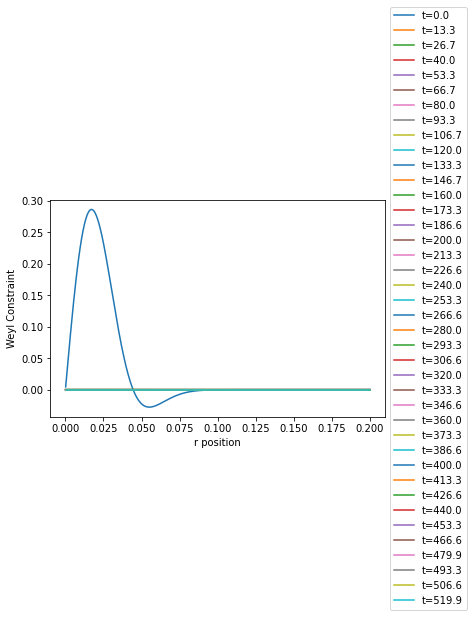

In [26]:
# Checa que se cumplan la constricción del W en la solución a cada tiempo 

WCheck = np.zeros( (len(tspan),n+1) )

for i in range(n+1):
    if i == 0:
        WCheck[:,i] = QSol[:,i]*sigSol[:,i]/2. + QSol[:,i]*ThSol[:,i]/2. -a/(h*2.)*(PPSol[:,i+1]-PPSol[:,i])-3./2.*a*(PPSol[:,i]/YSol[:,i])*ChSol[:,i] - 1./6.*a*((rhoSol[:,i+1]+rhobSol[:,i+1]-rhoSol[:,i]-rhobSol[:,i])/h) - (a*WSol[:,i]/YSol[:,i])*ChSol[:,i]-a/3.*((WSol[:,i+1]-WSol[:,i])/h)
    else:
        WCheck[:,i] = QSol[:,i]*sigSol[:,i]/2. + QSol[:,i]*ThSol[:,i]/2. -a/(h*2.)*(PPSol[:,i]-PPSol[:,i-1])-3./2.*a*(PPSol[:,i]/YSol[:,i])*ChSol[:,i] - 1./6.*a*((rhoSol[:,i]+rhobSol[:,i]-rhoSol[:,i-1]-rhobSol[:,i-1])/h) - (a*WSol[:,i]/YSol[:,i])*ChSol[:,i]-a/3.*((WSol[:,i]-WSol[:,i-1])/h)

for i in range(0, len(tspan), 25):
    plt.plot(r, WCheck[i,:], label='t={0:1.1f}'.format(tspan[i]))
    
# put legend outside the figure
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('r position')
plt.ylabel('Weyl Constraint')
        
print(WCheck)

# Deltas promedio

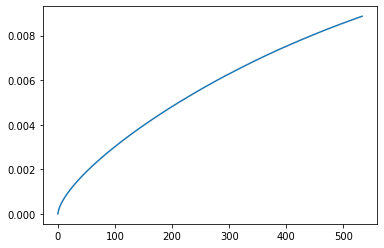

In [27]:
#Busca los cruces con el eje x de la función delta (para CDM)identificando 
#cambios de signo para cada tiempo

zero_crossings = np.zeros(len(tspan))

for i in range(0,len(tspan)):
    zero_crossings[i] = np.where(np.diff(np.sign(deltaSol[i,:])))[0][0]

zc = np.zeros(len(tspan))

for i in range(0,len(tspan)):
    zc[i] = int(zero_crossings[i]) 
    
#Define un arreglo anulando todos los valores de delta1 antes del valor de cruce

delta1 = np.zeros((len(tspan),n+1))


for j in range (len(tspan)):
    for i in range(int(zc[j]),n+1):
        delta1[j,i] = deltaSol[j,i] 
    
Y1 = np.zeros((len(tspan),n+1))

for j in range (len(tspan)):
    for i in range(int(zc[j]),n+1):
        Y1[j,i] = YSol[j,i] 
        
B1 = np.zeros((len(tspan),n+1))

for j in range (len(tspan)):
    for i in range(int(zc[j]),n+1):
        B1[j,i] = BSol[j,i] 
        
#realiza la integral de los ejes r para calcular el promedio

promd1 = np.zeros(len(tspan))
vol1 = np.zeros(len(tspan))

for j in range(len(tspan)):
    promd1[j] = np.trapz(delta1[j,:]*Y1[j,:]*B1[j,:],x = r)
    vol1[j] = np.trapz(Y1[j,:]*B1[j,:],x = r)

deltaprom1 = promd1/vol1

plt.plot(tspan, deltaprom1)

#print(deltaprom1)

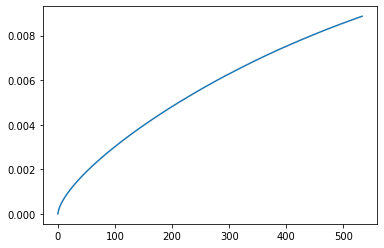

In [28]:
#realiza lo mismo que la celda anterior pero para bariones

zero_crossingsb = np.zeros(len(tspan))

for i in range(0,len(tspan)):
    zero_crossingsb[i] = np.where(np.diff(np.sign(deltabSol[i,:])))[0][0]

zcb = np.zeros(len(tspan))

for i in range(0,len(tspan)):
    zcb[i] = int(zero_crossingsb[i]) 

deltab1 = np.zeros((len(tspan),n+1))


for j in range (len(tspan)):
    for i in range(int(zcb[j]),n+1):
        deltab1[j,i] = deltabSol[j,i] 
    
Yb1 = np.zeros((len(tspan),n+1))

for j in range (len(tspan)):
    for i in range(int(zcb[j]),n+1):
        Yb1[j,i] = YSol[j,i] 
        
Bb1 = np.zeros((len(tspan),n+1))

for j in range (len(tspan)):
    for i in range(int(zcb[j]),n+1):
        Bb1[j,i] = BSol[j,i] 

promdb1 = np.zeros(len(tspan))
volb1 = np.zeros(len(tspan))

for j in range(len(tspan)):
    promdb1[j] = np.trapz(deltab1[j,:]*Yb1[j,:]*Bb1[j,:],x = r)
    volb1[j] = np.trapz(Yb1[j,:]*Bb1[j,:],x = r)

deltapromb1 = promdb1/volb1

plt.plot(tspan, deltapromb1)

#print(deltapromb1)

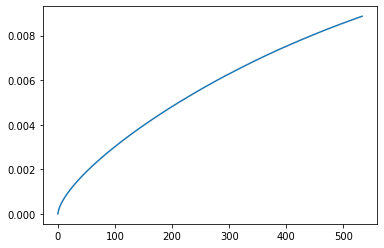

In [29]:
#realiza el mismo procedimiento que en la celda anterior pero para la delta total

zero_crossingsT = np.zeros(len(tspan))

for i in range(0,len(tspan)):
    zero_crossingsT[i] = np.where(np.diff(np.sign(deltaTSol[i,:])))[0][0]

zcT = np.zeros(len(tspan))

for i in range(0,len(tspan)):
    zcT[i] = int(zero_crossingsT[i]) 

deltaT = np.zeros((len(tspan),n+1))


for j in range (len(tspan)):
    for i in range(int(zcT[j]),n+1):
        deltaT[j,i] = deltaTSol[j,i] 
    
YT = np.zeros((len(tspan),n+1))

for j in range (len(tspan)):
    for i in range(int(zcT[j]),n+1):
        YT[j,i] = YSol[j,i] 
        
BT = np.zeros((len(tspan),n+1))

for j in range (len(tspan)):
    for i in range(int(zcT[j]),n+1):
        BT[j,i] = BSol[j,i] 

promdT = np.zeros(len(tspan))
volT = np.zeros(len(tspan))

for j in range(len(tspan)):
    promdT[j] = np.trapz(deltaT[j,:]*YT[j,:]*BT[j,:],x = r)
    volT[j] = np.trapz(YT[j,:]*BT[j,:],x = r)

deltapromT = promdT/volT

plt.plot(tspan, deltapromT)

#print(deltaprom1)

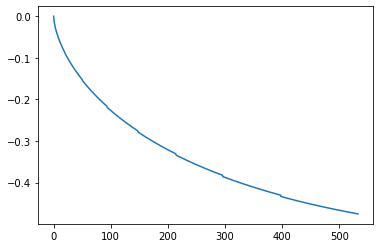

In [30]:
#realiza el mismo cálculo de las deltas pero para la infradensidad de CDM


deltaV1 = np.zeros((len(tspan),n+1))


for j in range (len(tspan)):
    for i in range(0,int(zc[j])):
        deltaV1[j,i] = deltaSol[j,i] 
    
YV1 = np.zeros((len(tspan),n+1))

for j in range (len(tspan)):
    for i in range(0,int(zc[j])):
        YV1[j,i] = YSol[j,i] 
        
BV1 = np.zeros((len(tspan),n+1))

for j in range (len(tspan)):
    for i in range(0,int(zc[j])):
        BV1[j,i] = BSol[j,i] 

promdV1 = np.zeros(len(tspan))
volV1 = np.zeros(len(tspan))


for j in range(len(tspan)):
    promdV1[j] = np.trapz(deltaV1[j,:]*YV1[j,:]*BV1[j,:],x = r)
    volV1[j] = np.trapz(YV1[j,:]*BV1[j,:],x = r)

deltapromV1 = promdV1/volV1

plt.plot(tspan, deltapromV1)

#print(deltapromV1)

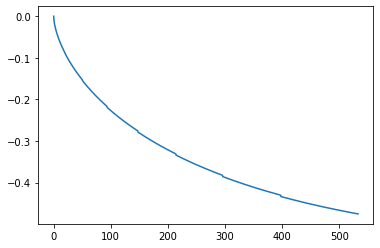

In [31]:
#realiza el mismo cálculo de las deltas pero para la infradensidad de bariones


zcb = np.zeros(len(tspan))

for i in range(1,len(tspan)):
    zcb[i] = int(zero_crossingsb[i]) 

deltaVb1 = np.zeros((len(tspan),n+1))


for j in range (len(tspan)):
    for i in range(0,int(zcb[j])):
        deltaVb1[j,i] = deltabSol[j,i] 
    
YVb1 = np.zeros((len(tspan),n+1))

for j in range (len(tspan)):
    for i in range(0,int(zcb[j])):
        YVb1[j,i] = YSol[j,i] 
        
BVb1 = np.zeros((len(tspan),n+1))

for j in range (len(tspan)):
    for i in range(0,int(zcb[j])):
        BVb1[j,i] = BSol[j,i] 

promdVb1 = np.zeros(len(tspan))
volVb1 = np.zeros(len(tspan))

for j in range(len(tspan)):
    promdVb1[j] = np.trapz(deltaVb1[j,:]*YVb1[j,:]*BVb1[j,:],x = r)
    volVb1[j] = np.trapz(YVb1[j,:]*BVb1[j,:],x = r)

deltapromVb1 = np.zeros(len(tspan))    
    
for i in range(len(tspan)):
    if i == 0:
        deltapromVb1[i] = 0
    else:
        deltapromVb1[i] = promdVb1[i]/volVb1[i]
        

plt.plot(tspan, deltapromVb1)

#print(deltapromVb1)

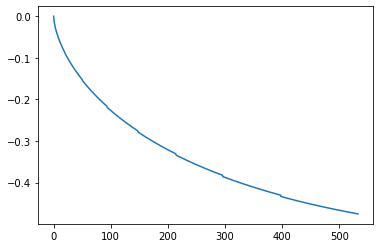

In [32]:
#realiza el mismo cálculo de las deltas pero para la infradensidad de CDM


deltaVT = np.zeros((len(tspan),n+1))


for j in range (len(tspan)):
    for i in range(0,int(zcT[j])):
        deltaVT[j,i] = deltaSol[j,i] 
    
YVT = np.zeros((len(tspan),n+1))

for j in range (len(tspan)):
    for i in range(0,int(zcT[j])):
        YVT[j,i] = YSol[j,i] 
        
BVT = np.zeros((len(tspan),n+1))

for j in range (len(tspan)):
    for i in range(0,int(zcT[j])):
        BVT[j,i] = BSol[j,i] 

promdVT = np.zeros(len(tspan))
volVT = np.zeros(len(tspan))


for j in range(len(tspan)):
    promdVT[j] = np.trapz(deltaVT[j,:]*YVT[j,:]*BVT[j,:],x = r)
    volVT[j] = np.trapz(YVT[j,:]*BVT[j,:],x = r)

deltapromVT = promdVT/volVT

plt.plot(tspan, deltapromVT)

#print(deltapromV1)

# Funciones de crecimiento f

<ipython-input-34-69f590fc4871>:3: RuntimeWarning: invalid value encountered in log
  logdeltaS = np.log(deltaprom1)
<ipython-input-34-69f590fc4871>:4: RuntimeWarning: invalid value encountered in log
  logdeltabS = np.log(deltapromb1)
<ipython-input-34-69f590fc4871>:7: RuntimeWarning: divide by zero encountered in log
  logdeltabVS = np.log(abs(deltapromVb1))


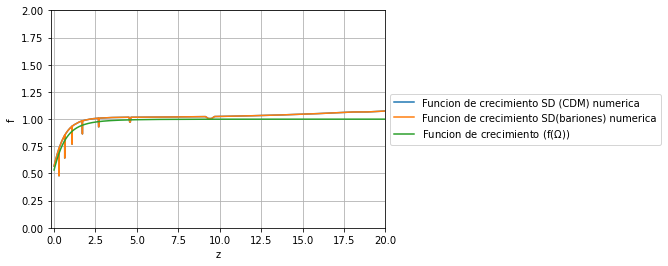

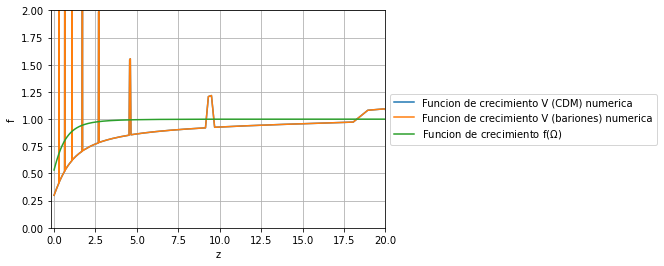

In [34]:
#intento de cálculo para f=dlogdelta/dloga para la suma de deltas de CDM y B para la sobredensidad

logdeltaS = np.log(deltaprom1)
logdeltabS = np.log(deltapromb1)

logdeltaVS = np.log(abs(deltapromV1))
logdeltabVS = np.log(abs(deltapromVb1))

loga = np.log(BSol[:,-1])


#gf = np.diff(logdelta) / np.diff(loga)
#gfb = np.diff(logdeltab) / np.diff(loga)  

gfS = np.gradient(logdeltaS, loga)
gfbS = np.gradient(logdeltabS, loga)
gfVS = np.gradient(logdeltaVS, loga)
gfbVS = np.gradient(logdeltabVS, loga)

fOm = ((rhoSol[:,-1]+rhobSol[:,-1])/ThSol[:,-1]**2.)**(6./11.)



#no se si sirve de algo pero también los grafica

plt.figure(1)

plt.plot(z1,gfS,label='Funcion de crecimiento SD (CDM) numerica')
plt.plot(z1,gfbS,label='Funcion de crecimiento SD(bariones) numerica')
plt.plot(z1,fOm,label='Funcion de crecimiento (f($\Omega$))')

axes = plt.gca()
axes.set_xlim([-0.2,20])
axes.set_ylim([0,2])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('z')
plt.ylabel('f')
plt.grid(True)

#plt.savefig('fOm1.png',bbox_inches='tight')

#intento de cálculo para f=dlogdelta/dloga para la suma de deltas de CDM y B para el void

plt.figure(2)

plt.plot(z1,gfVS,label='Funcion de crecimiento V (CDM) numerica')
plt.plot(z1,gfbVS,label='Funcion de crecimiento V (bariones) numerica')
plt.plot(z1,fOm,label='Funcion de crecimiento f($\Omega$)')

axes = plt.gca()
axes.set_xlim([-0.2,20])
axes.set_ylim([0,2])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('z')
plt.ylabel('f')
plt.grid(True)

#plt.savefig('fOmV1.png',bbox_inches='tight')


#print(fOm)

<ipython-input-35-9abfd1f188ad>:3: RuntimeWarning: invalid value encountered in log
  logdeltaT = np.log(deltapromT)


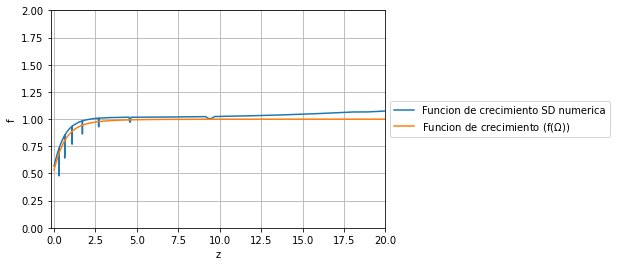

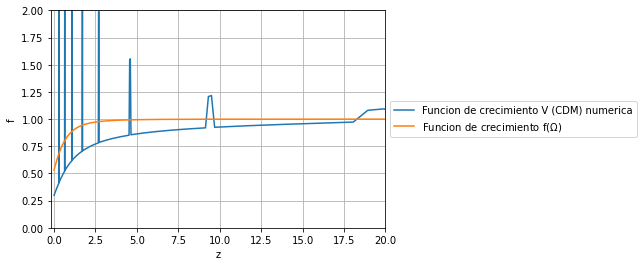

In [35]:
#intento de cálculo para f=dlogdelta/dloga para la suma de deltas de CDM y B para la sobredensidad

logdeltaT = np.log(deltapromT)

logdeltaVT = np.log(abs(deltapromVT))


#gf = np.diff(logdelta) / np.diff(loga)
#gfb = np.diff(logdeltab) / np.diff(loga)  

gfT = np.gradient(logdeltaT, loga)
gfVT = np.gradient(logdeltaVT, loga)

#no se si sirve de algo pero también los grafica

plt.figure(1)

plt.plot(z1,gfT,label='Funcion de crecimiento SD numerica')
plt.plot(z1,fOm,label='Funcion de crecimiento (f($\Omega$))')

axes = plt.gca()
axes.set_xlim([-0.2,20])
axes.set_ylim([0,2])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('z')
plt.ylabel('f')
plt.grid(True)

#plt.savefig('fOm1.png',bbox_inches='tight')

#intento de cálculo para f=dlogdelta/dloga para la suma de deltas de CDM y B para el void

plt.figure(2)

plt.plot(z1,gfVT,label='Funcion de crecimiento V (CDM) numerica')
plt.plot(z1,fOm,label='Funcion de crecimiento f($\Omega$)')

axes = plt.gca()
axes.set_xlim([-0.2,20])
axes.set_ylim([0,2])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('z')
plt.ylabel('f')
plt.grid(True)

#plt.savefig('fOmV1.png',bbox_inches='tight')


#print(fOm)

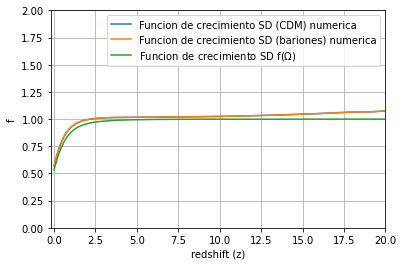

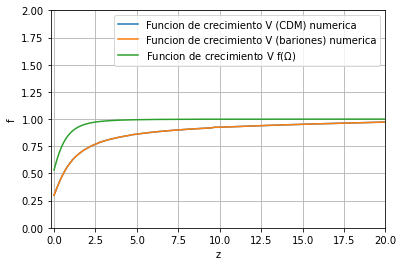

In [36]:
#Intento de eliminar los puntos feos de las gráficas anteriores

gfSC = np.zeros(len(tspan))
gfbSC = np.zeros(len(tspan))
gfVSC = np.zeros(len(tspan))
gfbVSC = np.zeros(len(tspan))

#discrimina los valores feos de los datos con un criterio de comparación con datos adyacentes, como los datos 
#feos vienen en pares, se realiza este criterio dos veces para OD y dos para voids la primer correción es 
# gfSC y la segunda gfSCC (ya me acordé S es por ser la suma de deltaprom1 + deltapromb1)

for i in range(0,len(tspan)):
    if i == 0:
        gfSC[i] = gfS[i]
    elif i > 0 and i < len(tspan)-1:
        uwuS1 = abs(gfS[i+1]/gfS[i])
        #print(uwu)
        if uwuS1 > 1:
            gfSC[i] = gfS[i-1]
        else:
            gfSC[i] = gfS[i]
    else:
        gfSC[i] = gfS[i]
        
for i in range(0,len(tspan)):
    if i == 0:
        gfbSC[i] = gfbS[i]
    elif i > 0 and i < len(tspan)-1:
        uwubS1 = abs(gfbS[i+1]/gfbS[i])
        #print(uwu)
        if uwubS1 > 1:
            gfbSC[i] = gfbS[i-1]
        else:
            gfbSC[i] = gfbS[i]
    else:
        gfbSC[i] = gfbS[i]
        
for i in range(0,len(tspan)):
    if i == 0:
        gfVSC[i] = gfVS[i]
    elif i > 0 and i < len(tspan)-1:
        uwuS2 = abs(gfVS[i+1]/gfVS[i])
        #print(uwu)
        if uwuS2 < 1:
            gfVSC[i] = gfVS[i+1]
        else:
            gfVSC[i] = gfVS[i]
    else:
        gfVSC[i] = gfVS[i]
        
for i in range(0,len(tspan)):
    if i == 0:
        gfbVSC[i] = gfbVS[i]
    elif i > 0 and i < len(tspan)-1:
        uwubS2 = abs(gfbVS[i+1]/gfbVS[i])
        #print(uwu)
        if uwubS2 < 1:
            gfbVSC[i] = gfbVS[i+1]
        else:
            gfbVSC[i] = gfbVS[i]
    else:
        gfbVSC[i] = gfbVS[i]
        
gfSCC = np.zeros(len(tspan))
gfbSCC = np.zeros(len(tspan))
gfVSCC = np.zeros(len(tspan))
gfbVSCC = np.zeros(len(tspan))

for i in range(0,len(tspan)):
    if i == 0:
        gfSCC[i] = gfSC[i]
    elif i > 0 and i < len(tspan)-1:
        owoS2 = abs(gfSC[i+1]/gfSC[i])
        #print(owo)
        if owoS2 > 1:
            gfSCC[i] = gfSC[i-1]
        else:
            gfSCC[i] = gfSC[i]
    else:
        gfSCC[i] = gfSC[i]
        
for i in range(0,len(tspan)):
    if i == 0:
        gfbSCC[i] = gfbSC[i]
    elif i > 0 and i < len(tspan)-1:
        owobS2 = abs(gfbSC[i+1]/gfbSC[i])
        #print(owo)
        if owobS2 > 1:
            gfbSCC[i] = gfbSC[i-1]
        else:
            gfbSCC[i] = gfbSC[i]
    else:
        gfbSCC[i] = gfbSC[i]
        
for i in range(0,len(tspan)):
    if i == 0:
        gfVSCC[i] = gfVSC[i]
    elif i > 0 and i < len(tspan)-1:
        owoS1 = abs(gfVSC[i+1]/gfVSC[i])
        #print(owo)
        if owoS1 < 1:
            gfVSCC[i] = gfVSC[i+1]
        else:
            gfVSCC[i] = gfVSC[i]
    else:
        gfVSCC[i] = gfVSC[i]
        
for i in range(0,len(tspan)):
    if i == 0:
        gfbVSCC[i] = gfbVSC[i]
    elif i > 0 and i < len(tspan)-1:
        owobS1 = abs(gfbVSC[i+1]/gfbVSC[i])
        #print(owo)
        if owobS1 < 1:
            gfbVSCC[i] = gfbVSC[i+1]
        else:
            gfbVSCC[i] = gfbVSC[i]
    else:
        gfbVSCC[i] = gfbVSC[i]

plt.figure(1)

plt.plot(z1,gfSCC,label='Funcion de crecimiento SD (CDM) numerica')
plt.plot(z1,gfbSCC,label='Funcion de crecimiento SD (bariones) numerica')
plt.plot(z1,fOm,label='Funcion de crecimiento SD f($\Omega$)')

axes = plt.gca()
axes.set_xlim([-0.2,20])
axes.set_ylim([0,2])

plt.legend(loc="upper right")
plt.xlabel(r'redshift (z)')
plt.ylabel('f')

plt.grid(True)

#plt.savefig('fOm.png',bbox_inches='tight')

plt.figure(2)

plt.plot(z1,gfVSCC,label='Funcion de crecimiento V (CDM) numerica')
plt.plot(z1,gfbVSCC,label='Funcion de crecimiento V (bariones) numerica')
plt.plot(z1,fOm,label='Funcion de crecimiento V f($\Omega$)')

axes = plt.gca()
axes.set_xlim([-0.2,20])
axes.set_ylim([0,2])

plt.legend(loc="upper right")
plt.xlabel('z')
plt.ylabel('f')

plt.grid(True)

#plt.savefig('fOmV.png',bbox_inches='tight')

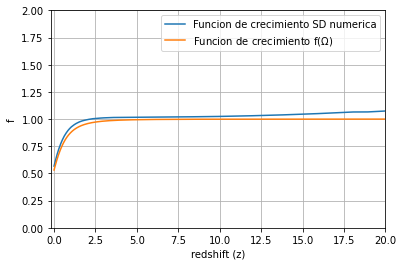

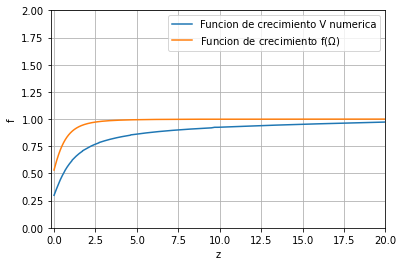

In [37]:
#Intento de eliminar los puntos feos de las gráficas anteriores

gfTC = np.zeros(len(tspan))
gfVTC = np.zeros(len(tspan))

#discrimina los valores feos de los datos con un criterio de comparación con datos adyacentes, como los datos 
#feos vienen en pares, se realiza este criterio dos veces para OD y dos para voids la primer correción es 
# gfSC y la segunda gfSCC (ya me acordé S es por ser la suma de deltaprom1 + deltapromb1)

for i in range(0,len(tspan)):
    if i == 0:
        gfTC[i] = gfT[i]
    elif i > 0 and i < len(tspan)-1:
        uwuT1 = abs(gfT[i+1]/gfT[i])
        #print(uwu)
        if uwuT1 > 1:
            gfTC[i] = gfT[i-1]
        else:
            gfTC[i] = gfT[i]
    else:
        gfTC[i] = gfT[i]

        
for i in range(0,len(tspan)):
    if i == 0:
        gfVTC[i] = gfVT[i]
    elif i > 0 and i < len(tspan)-1:
        uwuT2 = abs(gfVT[i+1]/gfVT[i])
        #print(uwu)
        if uwuT2 < 1:
            gfVTC[i] = gfVT[i+1]
        else:
            gfVTC[i] = gfVT[i]
    else:
        gfVTC[i] = gfVT[i]

        
gfTCC = np.zeros(len(tspan))
gfVTCC = np.zeros(len(tspan))

for i in range(0,len(tspan)):
    if i == 0:
        gfTCC[i] = gfTC[i]
    elif i > 0 and i < len(tspan)-1:
        owoT2 = abs(gfTC[i+1]/gfTC[i])
        #print(owo)
        if owoT2 > 1:
            gfTCC[i] = gfTC[i-1]
        else:
            gfTCC[i] = gfTC[i]
    else:
        gfTCC[i] = gfTC[i]
        

for i in range(0,len(tspan)):
    if i == 0:
        gfVTCC[i] = gfVTC[i]
    elif i > 0 and i < len(tspan)-1:
        owoT1 = abs(gfVTC[i+1]/gfVTC[i])
        #print(owo)
        if owoT1 < 1:
            gfVTCC[i] = gfVTC[i+1]
        else:
            gfVTCC[i] = gfVTC[i]
    else:
        gfVTCC[i] = gfVTC[i]


plt.figure(1)

plt.plot(z1,gfTCC,label='Funcion de crecimiento SD numerica')
plt.plot(z1,fOm,label='Funcion de crecimiento f($\Omega$)')

axes = plt.gca()
axes.set_xlim([-0.2,20])
axes.set_ylim([0,2])

plt.legend(loc="upper right")
plt.xlabel(r'redshift (z)')
plt.ylabel('f')

plt.grid(True)

#plt.savefig('fOmT.png',bbox_inches='tight')

plt.figure(2)

plt.plot(z1,gfVTCC,label='Funcion de crecimiento V numerica')
plt.plot(z1,fOm,label='Funcion de crecimiento f($\Omega$)')

axes = plt.gca()
axes.set_xlim([-0.2,20])
axes.set_ylim([0,2])

plt.legend(loc="upper right")
plt.xlabel('z')
plt.ylabel('f')

plt.grid(True)

#plt.savefig('fOmVT.png',bbox_inches='tight')

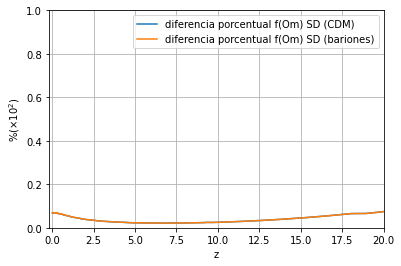

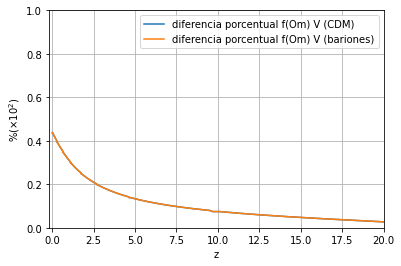

In [38]:
#calcula la diferencia porcentual entre el factor de crecimiento de f(omega) y los datos numéricos

fOmpercent = abs(gfSCC/fOm-1.)
fOmpercentb = abs(gfbSCC/fOm-1.)
fOmpercentV = abs(gfVSCC/fOm-1.)
fOmpercentbV = abs(gfbVSCC/fOm-1.)

plt.figure(1)

plt.plot(z1,fOmpercent,label='diferencia porcentual f(Om) SD (CDM)')
plt.plot(z1,fOmpercentb,label='diferencia porcentual f(Om) SD (bariones)')

axes = plt.gca()
axes.set_xlim([-0.2,20])
axes.set_ylim([0,1])

plt.legend(loc="upper right")
plt.xlabel('z')
plt.ylabel(r'%($\times 10^2$)')

plt.grid(True)

#plt.savefig('difporfOm.png',bbox_inches='tight')

plt.figure(2)

plt.plot(z1,fOmpercentV,label='diferencia porcentual f(Om) V (CDM)')
plt.plot(z1,fOmpercentbV,label='diferencia porcentual f(Om) V (bariones)')

axes = plt.gca()
axes.set_xlim([-0.2,20])
axes.set_ylim([0,1])

plt.legend(loc="upper right")
plt.xlabel('z')
plt.ylabel(r'%($\times 10^2$)')

plt.grid(True)

#plt.savefig('difporfOmV.png',bbox_inches='tight')



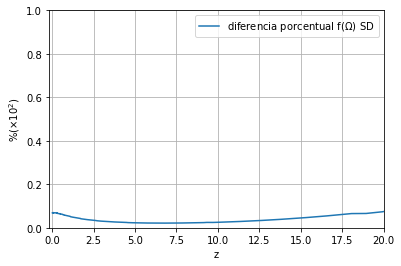

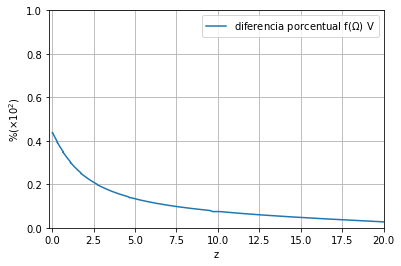

In [39]:
#calcula la diferencia porcentual entre el factor de crecimiento de f(omega) y los datos numéricos

fOmpercentT = abs(gfTCC/fOm-1.)
fOmpercentVT = abs(gfVTCC/fOm-1.)

plt.figure(1)

plt.plot(z1,fOmpercentT,label='diferencia porcentual f($\Omega$) SD')

axes = plt.gca()
axes.set_xlim([-0.2,20])
axes.set_ylim([0,1])

plt.legend(loc="upper right")
plt.xlabel('z')
plt.ylabel(r'%($\times 10^2$)')

plt.grid(True)

#plt.savefig('difporfOmT.png',bbox_inches='tight')

plt.figure(2)

plt.plot(z1,fOmpercentVT,label='diferencia porcentual f($\Omega$) V')

axes = plt.gca()
axes.set_xlim([-0.2,20])
axes.set_ylim([0,1])

plt.legend(loc="upper right")
plt.xlabel('z')
plt.ylabel(r'%($\times 10^2$)')

plt.grid(True)

#plt.savefig('difporfOmVT.png',bbox_inches='tight')


